# Sales Analytics: DSI Business Intelligence Capstone Project

## Introduction

The project presented is an extension of the twist challenge project [time-series-sales-analytics](https://github.com/SitwalaM/time-series-sales-analytics). The objective of the project is to implement a business intelligence pipeline for a small shop which gives the shop owner insights that can drive actionable insights. The main components of the project are;

### 1. Sales Forescasting

A sales forecasting model using Prophet is implemented to help the client (shop owner) plan for the month. The model is currently implementing a 7-day forecast as only 13 months of data is demonstrated here.

### 2. Customer Segmentation

Clustering is implemented using Recency, Frequency and Monetary value of each customer. The segmentation allows for the shop owner to target specific customers for promotions and retention calls.

### 3. Customer Growth Accounting

The customer growth accounting tracks the growth of customers and classifies them into the following categories;
* New: First time visitors
* Churned: Customers who haven't visited for 2 months consecutively (defined by the client)
* Regained: Previously churned customers who have visited the shop again.

Growth accounting is typically used in subscription based services but it can be a powerful insight in this scenario as salons have a database of regular visitors who can be treated as subcribers for analysis purposes.

### 4. Cloud Implementation and Orchestration

The implementation is planned for deployment completely in the cloud. A MySQL server was setup on and Amazon EC2. Apache Airflow is used for the pipeling orchestration with a daily interval. Currently, the extraction of the data is not done from the client premises. For demonstration purposes, the front-end application allows for the client to upload the latest sales data. Orchestraion is demonstrated on a Desktop PC in a completely virtual environment which can be deployed on the Amazon EC2- The t2.micro EC2 used for the project demonstration does not have enough capacity to install Prophet.





## Software

This section gives an overview of the main functions used in the pipeline. Functions will be imported into the notebook as the pipeline was refactored for easy deployment


In [4]:
%%capture
### Library Imports


import pandas as pd
from datetime import datetime as dt
from datetime import date,  timedelta
import s3fs
import configparser
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# main modules used in streamlit app and airflow orchestration

from scripts.growth_budget import  *        
from streamlit.app_utilities import *
from scripts.analytics_modules import *



In [5]:
# download latest dataset from S3 Bucket

file = str(date.today()) + ".csv"
config = configparser.ConfigParser()

 # pass credentials for s3
config.read("scripts/credentials.ini")  
key = config["aws"]["AWS_ACCESS_KEY_ID"]
secret = config["aws"]["AWS_SECRET_ACCESS_KEY"]


s3 = s3fs.S3FileSystem(anon=False, key=key, secret=secret)
customer_data = pd.read_csv('s3://salonanalytics/'+file)
customer_data.head()

,Unnamed: 0,Date,Customer,Total
0,0,2020-01,aea36f18ab8d7887628db66b6635d59ba348c4843e9519...,2.0
1,1,2020-01,0b5687f202fcf98d01c9bd071996b3f8066f70b4e16a49...,5.0
2,2,2020-01,fd7182047b43bfd58dcd1c9ccc55c889c9e862f89127df...,6.0
3,3,2020-01,58873afabbba45d3ee3b67e013f1f2be1b5a894f554ae6...,6.0
4,4,2020-01,a302152f779f5db64b74e2258525687738e050a704754f...,20.0


In [6]:
# fixes error in initial dataset due to wrong date formats
customer_data['Date']=pd.to_datetime(customer_data['Date'].astype(str))
customer_data = customer_data[customer_data['Date']> "2020-09-30"]

### Sales Time-Series by Month

In [7]:
grouped_month_df = group_by_month(customer_data)
grouped_month_df.head()

,Total
month-year,
2020-10,7947.4
2020-11,6858.6
2020-12,7709.6
2021-01,6683.8
2021-02,6309.4


Text(0, 0.5, 'Sales (ZMW)')

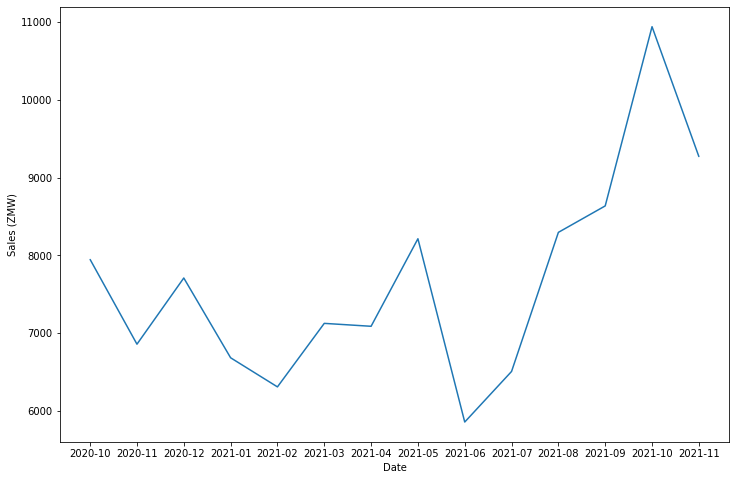

In [8]:
fig, ax = plt.subplots(figsize=(12,8))
sns.set()
sns.set()
sns.lineplot(x= grouped_month_df.index, y = grouped_month_df.Total)
plt.xlabel("Date")
plt.ylabel("Sales (ZMW)")

### Customer count by Month

In [9]:
grouped_customers_df = get_customers_per_month(customer_data)
grouped_customers_df.head()

,Customer
Date,
2020-10,485
2020-11,442
2020-12,465
2021-01,382
2021-02,381


In [10]:
grouped_customers_df.columns

Index(['Customer'], dtype='object')

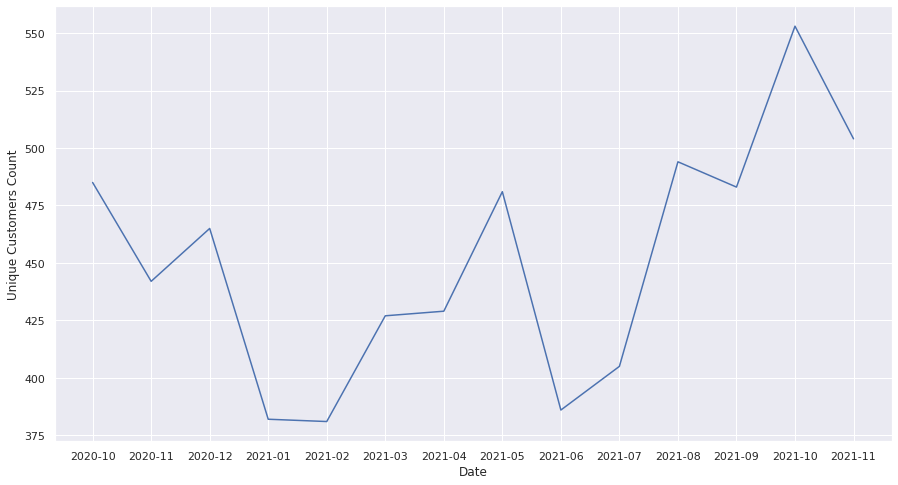

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
sns.set()
sns.lineplot(x= grouped_customers_df.index, y = grouped_customers_df.Customer)
plt.xlabel("Date")
plt.ylabel("Unique Customers Count")
plt.savefig("images/customer_count.png")

### Sales Forecasting

A prohphet model with a mean absolute error of 92.5 was used. Further details on the selection of the model selection can be found [here](https://github.com/SitwalaM/time-series-sales-analytics/blob/main/notebooks/salon_analytics_predictions.ipynb)

In [12]:
%%capture
# 7-Day Forecast
zambia_holidays = pd.DataFrame({
    'holiday': 'general',
    'ds': pd.to_datetime(['2021-01-01', '2021-03-12', '2021-04-10',
                            '2021-04-11', '2021-04-13', '2021-05-01',
                            '2021-07-07', '2021-08-03', '2021-10-19',
                            '2020-10-19', '2021-10-24', '2020-12-25']),
    'lower_window': 0,
    'upper_window': 1,
    })

ts = prepare_for_prophet(customer_data)                                # prepare data for prophet model
model = forecast_by_Prophet(ts, zambia_holidays)                       
forecast_df = make_forecast(model,refit = False,period=7, train_data = None)


Initial log joint probability = -13.2422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       686.129    0.00249741       95.3385           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       688.347   0.000144386       78.8258           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       688.363   4.22562e-05       83.1585   4.704e-07       0.001      295  LS failed, Hessian reset 
     299       688.415   0.000147712       87.1429           1           1      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     398       688.502   1.42405e-05        83.044   1.817e-07       0.001      567  LS failed, Hessian reset 
     399       688.502   1.08405e-05       96.1206           1           1      568   
    Iter      log pro

In [13]:
#show 7-day forecast

forecast_df.tail()

,ds,yhat,yhat_lower,yhat_upper,trend
420,2021-12-03,344.941699,170.978893,520.866333,246.989968
421,2021-12-04,509.160762,354.397972,695.593024,247.516282
422,2021-12-05,553.755632,367.762003,723.064605,248.042595
423,2021-12-06,259.032535,87.162653,415.526019,248.568909
424,2021-12-07,209.743397,35.870307,367.940861,249.095222


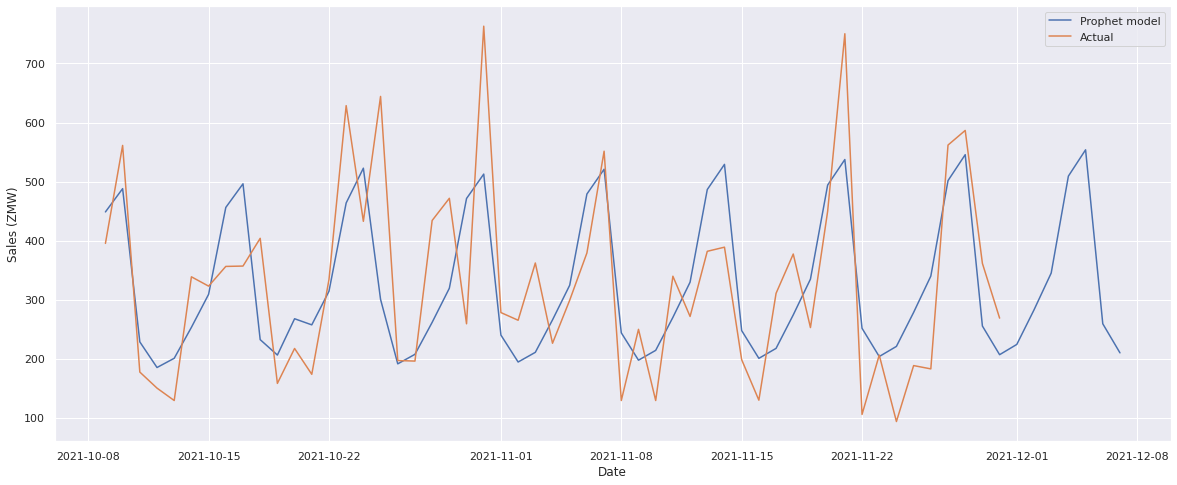

In [14]:
fig, ax = plt.subplots(figsize=(20,8))
sns.set()
sns.lineplot(x= forecast_df.ds[-60:], y = forecast_df.yhat[-60:], label = "Prophet model")
sns.lineplot(data = ts[-53:], x = "ds", y = "y", label = "Actual")
plt.xlabel("Date")
plt.ylabel("Sales (ZMW)")
plt.savefig("images/prophet_output.png")

### Customer Segmentation

Segmentation based on the frequency (how many purchases), recency (when last was purchase made in days) and Monetary (Total amount spent by customer)

In [15]:
# Get Recency, Frequency and Monetary data for each customer 

rfm_df = get_rfm_data(customer_data)
rfm_df.head()

,recency,monetary,frequency
Customer,,,
0025cc04d23e13a351d847f597cf61a09a5dc9cece7a6eb3e63a063eaa7488b8,239,17.0,1
002f03d7613e850bbe6f6f266b5aea1145a02c3fed7f832f5be19ce86e38c83c,240,8.0,1
003a0fa4defb64752e1b95055f6dab1d8d663e03260db6c8ae43db18a3247ce6,28,39.0,3
004d2932822812e34c826a2e465215263a3ce375ebae661461d0aa5d88fb9d81,112,17.0,1
00789b3648ab658e0d865904dc28eaa094d6fe7c56af1767d4747ecc6a4ec7d8,408,37.0,1


#### Clustering with Kmeans and View using [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [16]:
clustered_data = run_kmeans(rfm_df, 4)      #run kmeans for three clusters
clustered_data.head()

,recency,monetary,frequency,cluster
Customer,,,,
0025cc04d23e13a351d847f597cf61a09a5dc9cece7a6eb3e63a063eaa7488b8,239,17.0,1,0
002f03d7613e850bbe6f6f266b5aea1145a02c3fed7f832f5be19ce86e38c83c,240,8.0,1,0
003a0fa4defb64752e1b95055f6dab1d8d663e03260db6c8ae43db18a3247ce6,28,39.0,3,3
004d2932822812e34c826a2e465215263a3ce375ebae661461d0aa5d88fb9d81,112,17.0,1,3
00789b3648ab658e0d865904dc28eaa094d6fe7c56af1767d4747ecc6a4ec7d8,408,37.0,1,0


In [17]:
# run tsne on the dataframe

tsne = TSNE(n_components=3, verbose=0, random_state=123)
z = tsne.fit_transform(clustered_data.iloc[:,0:2])
tsne_df = pd.DataFrame()
tsne_df["y"] = clustered_data.cluster
tsne_df["comp-1"] = z[:,0]
tsne_df["comp-2"] = z[:,1]
tsne_df = tsne_df[tsne_df.y != -1]

/home/sitwala/linuxdevs/DSI/capstone/sales_business_intelligence_capstone/capstone_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sitwala/linuxdevs/DSI/capstone/sales_business_intelligence_capstone/capstone_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


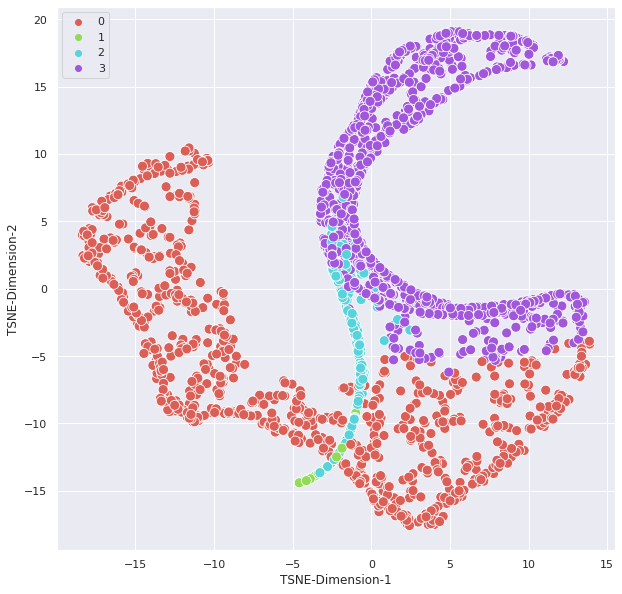

In [18]:
# plot tsne dimensions

fig, ax = plt.subplots(figsize=(10,10))
sns.set()
sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_df.y.tolist(),
                palette=sns.color_palette("hls", 4),
                data=tsne_df, s=100)
plt.xlabel("TSNE-Dimension-1")
plt.ylabel("TSNE-Dimension-2")
plt.savefig("images/tsne.png")

In [19]:
# assign segment to the clusters

segments_dictionary = {0: "1", 3: "2", 1: "3", 2: "4"}
clustered_data ["segment"] = clustered_data ["cluster"].map(segments_dictionary)
customer_segments = clustered_data .reset_index()
customer_segments.head()

,Customer,recency,monetary,frequency,cluster,segment
0,0025cc04d23e13a351d847f597cf61a09a5dc9cece7a6e...,239,17.0,1,0,1
1,002f03d7613e850bbe6f6f266b5aea1145a02c3fed7f83...,240,8.0,1,0,1
2,003a0fa4defb64752e1b95055f6dab1d8d663e03260db6...,28,39.0,3,3,2
3,004d2932822812e34c826a2e465215263a3ce375ebae66...,112,17.0,1,3,2
4,00789b3648ab658e0d865904dc28eaa094d6fe7c56af17...,408,37.0,1,0,1


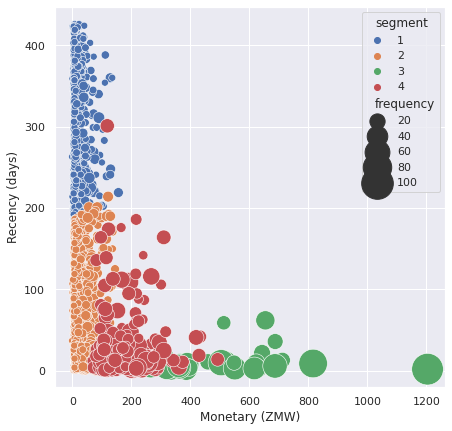

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
sns.set()
sns.scatterplot(data= customer_segments.sort_values("segment"), x= "monetary", y = "recency", size = "frequency", sizes = (50,1000), hue= "segment")
plt.xlabel("Monetary (ZMW)")
plt.ylabel("Recency (days)")
plt.savefig("images/cluster_plot.png")


In [21]:
#### summary of the customer segments

customer_segments.groupby('segment').agg(
    recency_mean=('recency','mean'),
    frequency_mean=('frequency','mean'),
    monetary_mean=('monetary','mean'),
    cluster_size=('Customer','count')
).round(1).sort_values(by='monetary_mean', ascending = False)

,recency_mean,frequency_mean,monetary_mean,cluster_size
segment,,,,
3,11.6,42.5,509.2,31
4,32.5,15.4,185.1,199
2,73.3,2.6,30.1,1269
1,306.8,1.5,17.6,948


### Customer Growth Accounting

The growth accounting tracks customer growth but take into account the churn, regained customers and new customers. This can help a business plan it's strategy.

In [22]:
growth_budget_df = get_growth_budget(customer_data)
growth_budget_df.head()

,Regained,New,Churned,months
4,20,138,197,2021-01
5,37,127,241,2021-02
6,67,135,163,2021-03
7,60,141,163,2021-04
8,68,156,180,2021-05


In [23]:
growth_budget_df["Net Growth"] = growth_budget_df.New + growth_budget_df.Regained - growth_budget_df.New

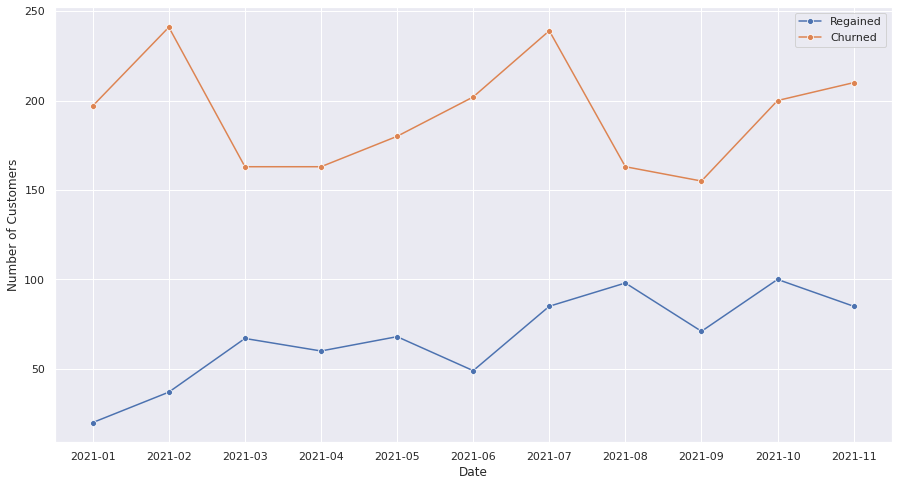

In [24]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = growth_budget_df, x="months", y="Regained", label = "Regained", marker = "o")
sns.lineplot(data = growth_budget_df, x="months", y="Churned", label = "Churned", marker = "o")
plt.xlabel("Date")
plt.ylabel("Number of Customers")
plt.savefig("images/regained_churned.png")


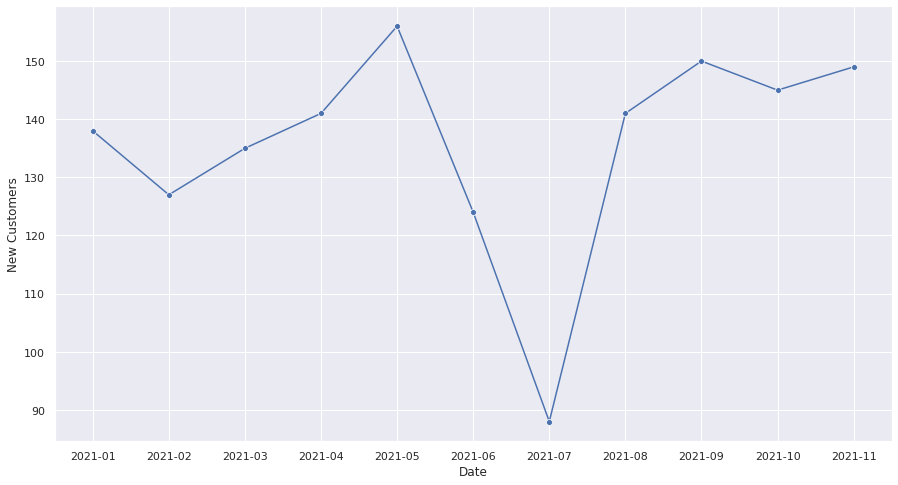

In [25]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = growth_budget_df, x="months", y="New", marker = "o")
plt.xlabel("Date")
plt.ylabel("New Customers")
plt.savefig("images/new_customers.png")

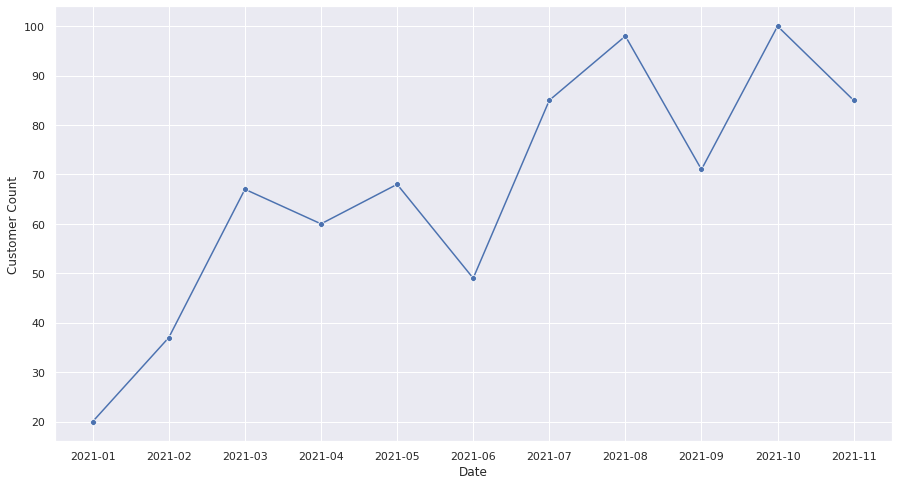

In [26]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data = growth_budget_df, x="months", y="Net Growth", marker = "o")
plt.xlabel("Date")
plt.ylabel("Customer Count")
plt.savefig("images/net_growth.png")

# Deployment

The methods above are used to display a front-end which can be used by the client which can be found [here](https://share.streamlit.io/sitwalam/sales_business_intelligence_capstone/main/streamlit/app.py). Until on-premises extraction is implemented, the shop owner can upload their latest sale data on the web front-end which is then uploaded to an S3 bucket. A mySQL database is implemmented on an AWS EC2 where the dataframes above are written to. Apache Airflow runs the ETL daily for the client to view insights

# Conculusions and Future Work



The insights presented above can provide a business owner a basis for decisions that can drive growth. 

* The simple forecasting model implemented helps the owner plan for stock and worker's availability
* The customer segmentation shows that less frequent and low spend customers drive most of the revenue. This insight can help drive strategy on marketing. 
* The growth accounting shows that rate of churn and new customers is almost stationary. Perhaps the definition of churn should be revised to more than two months

## Future Work

* On-Premises automated extraction of the data from the source
* Migration of the apache airflow orchestration from the Desktop PC to the cloud.
* Automated action recommendation for retention calls based on the output from the segmentation. For example, high spending customers with a poor recency should be offered a discount to return to the store.